In [ ]:
import pandas as pd

df = pd.read_excel("final_dataset_limited_600_per_category.xlsx")

In [ ]:
df

,project,type,category,title,publish_date,fronturl,picture,overview,text,word_count
0,РБК,short_news,Авто,Глава АвтоВАЗа заявил о снижении продаж в феврале,2025-02-25T22:18:33+03:00,https://www.rbc.ru/rbcfreenews/67be10c59a79474...,1,NaN,В феврале 2025 года концерн АвтоВАЗ ожидает сн...,304
1,РБК,short_news,Авто,Юрист напомнил о штрафах за мытье машины на да...,2025-03-23T10:32:08+03:00,https://www.rbc.ru/rbcfreenews/67dfb71e9a79479...,1,NaN,Сотрудники ГИБДД могут оштрафовать автомобилис...,290
2,РБК,short_news,Авто,Минпромторг представил список облагаемых налог...,2025-03-29T19:43:30+03:00,https://www.rbc.ru/rbcfreenews/67e81d279a7947d...,1,В первый список внесены 303 модели средней сто...,Минпромторг России составил список дорогостоящ...,333
3,Autonews,short_news,Авто,В России стартовали продажи Volkswagen Golf. Н...,2025-01-06T22:51:30+03:00,https://www.autonews.ru/news/677bdc9b9a7947668...,1,NaN,В России возобновили продажи новых хэтчбеков V...,175
4,Autonews,short_news,Авто,В России назвали самые популярные пикапы. Цены...,2025-01-06T15:11:35+03:00,https://www.autonews.ru/news/677bc85d9a7947904...,1,NaN,"В России резко вырос спрос на пикапы. Так, по ...",403
...,...,...,...,...,...,...,...,...,...,...
5395,РБК,short_news,Экономика,В МИДе заявили о нежелании Европы отказываться...,2024-02-21T08:47:23+03:00,https://www.rbc.ru/rbcfreenews/65d586599a79475...,1,NaN,Россия намерена развивать сотрудничество в эне...,272
5396,РБК,article,Экономика,Власти внедрят в законодательство понятие «лес...,2024-02-21T07:00:17+03:00,https://www.rbc.ru/economics/21/02/2024/65d31b...,1,В правительство внесли поправки в Лесной кодек...,Минприроды разработало проект поправок в Лесно...,1013
5397,РБК,article,Экономика,США продлили разрешение на импорт российских л...,2024-02-20T23:15:03+03:00,https://www.rbc.ru/economics/20/02/2024/65d503...,1,"Российская рыба, морепродукты и продукция их п...","Операции, связанные с импортом российских лосо...",332
5398,РБК,article,Экономика,Украина решила создать дополнительный маршрут ...,2024-02-20T22:06:18+03:00,https://www.rbc.ru/economics/20/02/2024/65d4d7...,1,Киев решил организовать контейнерные перевозки...,Министр инфраструктуры Украины Александр Кубра...,506


In [ ]:
df = df.dropna(subset=['title', 'overview', 'text'], how='all')

In [ ]:
df

,project,type,category,title,publish_date,fronturl,picture,overview,text,word_count
0,РБК,short_news,Авто,Глава АвтоВАЗа заявил о снижении продаж в феврале,2025-02-25T22:18:33+03:00,https://www.rbc.ru/rbcfreenews/67be10c59a79474...,1,NaN,В феврале 2025 года концерн АвтоВАЗ ожидает сн...,304
1,РБК,short_news,Авто,Юрист напомнил о штрафах за мытье машины на да...,2025-03-23T10:32:08+03:00,https://www.rbc.ru/rbcfreenews/67dfb71e9a79479...,1,NaN,Сотрудники ГИБДД могут оштрафовать автомобилис...,290
2,РБК,short_news,Авто,Минпромторг представил список облагаемых налог...,2025-03-29T19:43:30+03:00,https://www.rbc.ru/rbcfreenews/67e81d279a7947d...,1,В первый список внесены 303 модели средней сто...,Минпромторг России составил список дорогостоящ...,333
3,Autonews,short_news,Авто,В России стартовали продажи Volkswagen Golf. Н...,2025-01-06T22:51:30+03:00,https://www.autonews.ru/news/677bdc9b9a7947668...,1,NaN,В России возобновили продажи новых хэтчбеков V...,175
4,Autonews,short_news,Авто,В России назвали самые популярные пикапы. Цены...,2025-01-06T15:11:35+03:00,https://www.autonews.ru/news/677bc85d9a7947904...,1,NaN,"В России резко вырос спрос на пикапы. Так, по ...",403
...,...,...,...,...,...,...,...,...,...,...
5395,РБК,short_news,Экономика,В МИДе заявили о нежелании Европы отказываться...,2024-02-21T08:47:23+03:00,https://www.rbc.ru/rbcfreenews/65d586599a79475...,1,NaN,Россия намерена развивать сотрудничество в эне...,272
5396,РБК,article,Экономика,Власти внедрят в законодательство понятие «лес...,2024-02-21T07:00:17+03:00,https://www.rbc.ru/economics/21/02/2024/65d31b...,1,В правительство внесли поправки в Лесной кодек...,Минприроды разработало проект поправок в Лесно...,1013
5397,РБК,article,Экономика,США продлили разрешение на импорт российских л...,2024-02-20T23:15:03+03:00,https://www.rbc.ru/economics/20/02/2024/65d503...,1,"Российская рыба, морепродукты и продукция их п...","Операции, связанные с импортом российских лосо...",332
5398,РБК,article,Экономика,Украина решила создать дополнительный маршрут ...,2024-02-20T22:06:18+03:00,https://www.rbc.ru/economics/20/02/2024/65d4d7...,1,Киев решил организовать контейнерные перевозки...,Министр инфраструктуры Украины Александр Кубра...,506


In [ ]:
df[['title', 'overview', 'text']] = df[['title', 'overview', 'text']].fillna('')

df['fulltext'] = df['title'] + ' ' + df['overview'] + ' ' + df['text']

In [ ]:
df

,project,type,category,title,publish_date,fronturl,picture,overview,text,word_count,fulltext
0,РБК,short_news,Авто,Глава АвтоВАЗа заявил о снижении продаж в феврале,2025-02-25T22:18:33+03:00,https://www.rbc.ru/rbcfreenews/67be10c59a79474...,1,,В феврале 2025 года концерн АвтоВАЗ ожидает сн...,304,Глава АвтоВАЗа заявил о снижении продаж в февр...
1,РБК,short_news,Авто,Юрист напомнил о штрафах за мытье машины на да...,2025-03-23T10:32:08+03:00,https://www.rbc.ru/rbcfreenews/67dfb71e9a79479...,1,,Сотрудники ГИБДД могут оштрафовать автомобилис...,290,Юрист напомнил о штрафах за мытье машины на да...
2,РБК,short_news,Авто,Минпромторг представил список облагаемых налог...,2025-03-29T19:43:30+03:00,https://www.rbc.ru/rbcfreenews/67e81d279a7947d...,1,В первый список внесены 303 модели средней сто...,Минпромторг России составил список дорогостоящ...,333,Минпромторг представил список облагаемых налог...
3,Autonews,short_news,Авто,В России стартовали продажи Volkswagen Golf. Н...,2025-01-06T22:51:30+03:00,https://www.autonews.ru/news/677bdc9b9a7947668...,1,,В России возобновили продажи новых хэтчбеков V...,175,В России стартовали продажи Volkswagen Golf. Н...
4,Autonews,short_news,Авто,В России назвали самые популярные пикапы. Цены...,2025-01-06T15:11:35+03:00,https://www.autonews.ru/news/677bc85d9a7947904...,1,,"В России резко вырос спрос на пикапы. Так, по ...",403,В России назвали самые популярные пикапы. Цены...
...,...,...,...,...,...,...,...,...,...,...,...
5395,РБК,short_news,Экономика,В МИДе заявили о нежелании Европы отказываться...,2024-02-21T08:47:23+03:00,https://www.rbc.ru/rbcfreenews/65d586599a79475...,1,,Россия намерена развивать сотрудничество в эне...,272,В МИДе заявили о нежелании Европы отказываться...
5396,РБК,article,Экономика,Власти внедрят в законодательство понятие «лес...,2024-02-21T07:00:17+03:00,https://www.rbc.ru/economics/21/02/2024/65d31b...,1,В правительство внесли поправки в Лесной кодек...,Минприроды разработало проект поправок в Лесно...,1013,Власти внедрят в законодательство понятие «лес...
5397,РБК,article,Экономика,США продлили разрешение на импорт российских л...,2024-02-20T23:15:03+03:00,https://www.rbc.ru/economics/20/02/2024/65d503...,1,"Российская рыба, морепродукты и продукция их п...","Операции, связанные с импортом российских лосо...",332,США продлили разрешение на импорт российских л...
5398,РБК,article,Экономика,Украина решила создать дополнительный маршрут ...,2024-02-20T22:06:18+03:00,https://www.rbc.ru/economics/20/02/2024/65d4d7...,1,Киев решил организовать контейнерные перевозки...,Министр инфраструктуры Украины Александр Кубра...,506,Украина решила создать дополнительный маршрут ...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install datasets
# !pip install --upgrade transformers

### Data Analitics

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


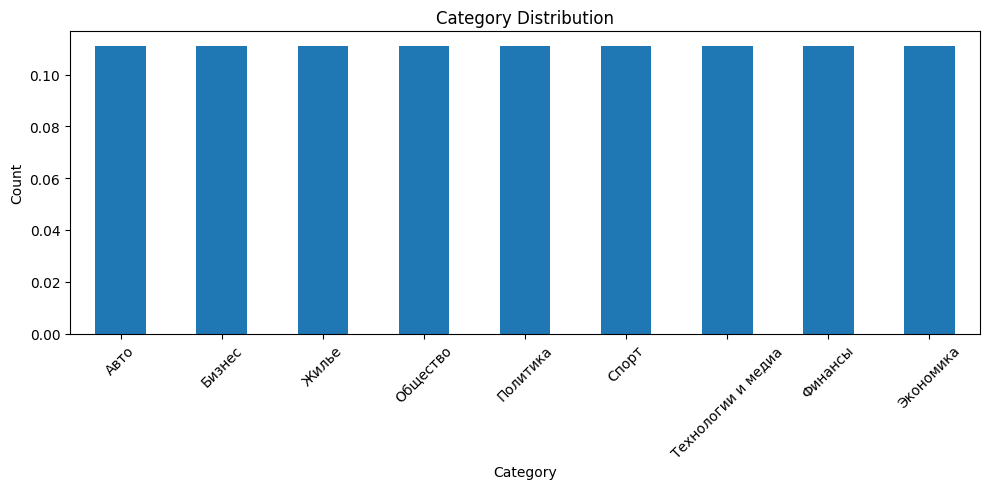

=== Анализ текста для BERT ===
Общее количество текстов: 5400
Количество уникальных категорий: 9
Количество дубликатов по полному тексту: 1

=== Топ-10 категорий по количеству:
category
Авто                  600
Бизнес                600
Жилье                 600
Общество              600
Политика              600
Спорт                 600
Технологии и медиа    600
Финансы               600
Экономика             600
Name: count, dtype: int64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer

# Инициализируем токенайзер BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Проверка баланса классов
category_counts = df['category'].value_counts(normalize=True)

# Проверка дубликатов
duplicate_count = df.duplicated(subset=['fulltext']).sum()

# Category distribution visualization
plt.figure(figsize=(10, 5))
category_counts.plot(kind='bar')
plt.title('Category Distribution')
plt.ylabel('Count')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Печатаем основные выводы
print("=== Анализ текста для BERT ===")
print(f"Общее количество текстов: {len(df)}")
print(f"Количество уникальных категорий: {df['category'].nunique()}")
print(f"Количество дубликатов по полному тексту: {duplicate_count}")
print("\n=== Топ-10 категорий по количеству:")
print(df['category'].value_counts().head(10))

### Data preparation

In [ ]:
# !pip install datasets

In [ ]:
from transformers import BertTokenizer
from datasets import Dataset
from sklearn.model_selection import train_test_split
import pandas as pd

# Загрузка модели и токенизатора
model_name = 'DeepPavlov/rubert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

# Создание колонки fulltext
df['fulltext'] = (
    df['title'].fillna('') + ' ' +
    df['overview'].fillna('') + ' ' +
    df['text'].fillna('')
)

# Разделение на train и test с сохранением пропорций классов
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['category']
)

# Создание словарей меток
label2id = {label: idx for idx, label in enumerate(df['category'].unique())}
id2label = {v: k for k, v in label2id.items()}

# Преобразование меток
train_df['label'] = train_df['category'].map(label2id)
test_df['label'] = test_df['category'].map(label2id)

# Преобразование в HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df[['fulltext', 'label']])
eval_dataset = Dataset.from_pandas(test_df[['fulltext', 'label']])

# Токенизация
def tokenize(example):
    return tokenizer(example['fulltext'], truncation=True, padding='max_length', max_length=512)

train_dataset = train_dataset.map(tokenize, batched=True)
eval_dataset = eval_dataset.map(tokenize, batched=True)


Map:   0%|          | 0/4320 [00:00<?, ? examples/s]

Map:   0%|          | 0/1080 [00:00<?, ? examples/s]

### ruBERT model

In [ ]:
!pip install -U transformers

In [ ]:
import transformers
print(transformers.__version__)

4.51.3


In [ ]:
from transformers import TrainingArguments
print(TrainingArguments.__module__)


transformers.training_args


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-18-7123c6f0b128>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



📘 Эпоха 1/10


Step,Training Loss
50,2.179500
100,1.848500
150,1.082200
200,0.843300
250,0.722900
300,0.538500
350,0.507800
400,0.524700
450,0.524100
500,0.480100


✅ Accuracy: 0.8361, Macro F1: 0.8354
                    precision    recall  f1-score   support

              Авто       0.96      0.97      0.97       120
            Бизнес       0.70      0.61      0.65       120
             Жилье       0.98      1.00      0.99       120
          Общество       0.72      0.80      0.76       120
          Политика       0.91      0.72      0.81       120
             Спорт       0.98      1.00      0.99       120
Технологии и медиа       0.83      0.83      0.83       120
           Финансы       0.83      0.87      0.85       120
         Экономика       0.65      0.72      0.68       120

          accuracy                           0.84      1080
         macro avg       0.84      0.84      0.84      1080
      weighted avg       0.84      0.84      0.84      1080

💾 Лучшая модель сохранена в ./best_model_final

📘 Эпоха 2/10


<ipython-input-18-7123c6f0b128>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,0.353200
100,0.468800
150,0.410900
200,0.399600
250,0.424700
300,0.521100
350,0.423200
400,0.494100
450,0.386700
500,0.340900


✅ Accuracy: 0.8444, Macro F1: 0.8430
                    precision    recall  f1-score   support

              Авто       0.97      0.97      0.97       120
            Бизнес       0.75      0.59      0.66       120
             Жилье       0.99      1.00      1.00       120
          Общество       0.74      0.77      0.75       120
          Политика       0.83      0.80      0.81       120
             Спорт       0.98      1.00      0.99       120
Технологии и медиа       0.84      0.88      0.86       120
           Финансы       0.82      0.86      0.84       120
         Экономика       0.67      0.73      0.70       120

          accuracy                           0.84      1080
         macro avg       0.84      0.84      0.84      1080
      weighted avg       0.84      0.84      0.84      1080

💾 Лучшая модель сохранена в ./best_model_final

📘 Эпоха 3/10


<ipython-input-18-7123c6f0b128>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,0.325600
100,0.266500
150,0.353300
200,0.396700
250,0.364100
300,0.347300
350,0.292400
400,0.390000
450,0.360000
500,0.299800


✅ Accuracy: 0.8444, Macro F1: 0.8451
                    precision    recall  f1-score   support

              Авто       0.99      0.98      0.99       120
            Бизнес       0.66      0.68      0.67       120
             Жилье       1.00      1.00      1.00       120
          Общество       0.76      0.77      0.76       120
          Политика       0.84      0.82      0.83       120
             Спорт       0.98      1.00      0.99       120
Технологии и медиа       0.85      0.82      0.84       120
           Финансы       0.86      0.84      0.85       120
         Экономика       0.66      0.69      0.67       120

          accuracy                           0.84      1080
         macro avg       0.85      0.84      0.85      1080
      weighted avg       0.85      0.84      0.85      1080

💾 Лучшая модель сохранена в ./best_model_final

📘 Эпоха 4/10


<ipython-input-18-7123c6f0b128>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,0.167600
100,0.240500
150,0.404500
200,0.261800
250,0.242400
300,0.304100
350,0.299400
400,0.306600
450,0.082800
500,0.286900


✅ Accuracy: 0.8454, Macro F1: 0.8455
                    precision    recall  f1-score   support

              Авто       1.00      0.96      0.98       120
            Бизнес       0.69      0.66      0.67       120
             Жилье       1.00      1.00      1.00       120
          Общество       0.74      0.74      0.74       120
          Политика       0.79      0.82      0.80       120
             Спорт       0.99      1.00      1.00       120
Технологии и медиа       0.87      0.88      0.87       120
           Финансы       0.86      0.87      0.86       120
         Экономика       0.68      0.69      0.69       120

          accuracy                           0.85      1080
         macro avg       0.85      0.85      0.85      1080
      weighted avg       0.85      0.85      0.85      1080

💾 Лучшая модель сохранена в ./best_model_final

📘 Эпоха 5/10


<ipython-input-18-7123c6f0b128>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,0.159800
100,0.191000
150,0.186700
200,0.216100
250,0.345300
300,0.259400
350,0.224200
400,0.187300
450,0.227700
500,0.161200


✅ Accuracy: 0.8435, Macro F1: 0.8428
                    precision    recall  f1-score   support

              Авто       0.97      0.97      0.97       120
            Бизнес       0.67      0.65      0.66       120
             Жилье       1.00      1.00      1.00       120
          Общество       0.79      0.69      0.74       120
          Политика       0.79      0.83      0.81       120
             Спорт       0.98      1.00      0.99       120
Технологии и медиа       0.82      0.88      0.85       120
           Финансы       0.90      0.86      0.88       120
         Экономика       0.67      0.71      0.69       120

          accuracy                           0.84      1080
         macro avg       0.84      0.84      0.84      1080
      weighted avg       0.84      0.84      0.84      1080

⚠️  Нет улучшения F1 (1/2)

📘 Эпоха 6/10


<ipython-input-18-7123c6f0b128>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,0.136800
100,0.077600
150,0.176500
200,0.267600
250,0.213200
300,0.097900
350,0.169000
400,0.164300
450,0.243200
500,0.075400


✅ Accuracy: 0.8333, Macro F1: 0.8326
                    precision    recall  f1-score   support

              Авто       0.98      0.97      0.97       120
            Бизнес       0.64      0.66      0.65       120
             Жилье       1.00      1.00      1.00       120
          Общество       0.80      0.68      0.73       120
          Политика       0.78      0.87      0.82       120
             Спорт       0.98      1.00      0.99       120
Технологии и медиа       0.82      0.81      0.81       120
           Финансы       0.83      0.86      0.84       120
         Экономика       0.67      0.67      0.67       120

          accuracy                           0.83      1080
         macro avg       0.83      0.83      0.83      1080
      weighted avg       0.83      0.83      0.83      1080

⚠️  Нет улучшения F1 (2/2)
⛔ Early stopping: F1 не улучшается.
🎯 Финальная модель сохранена в ./final_model_early_stopped


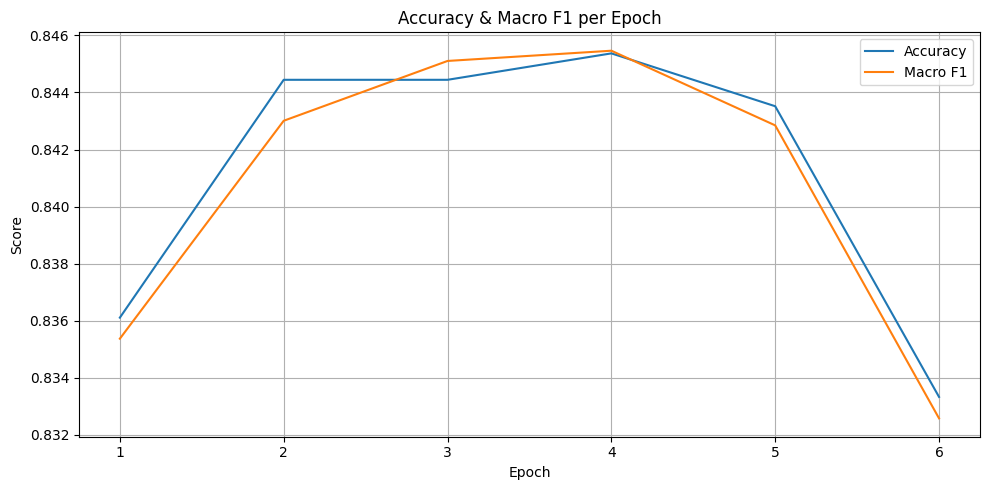

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
from transformers import BertForSequenceClassification, TrainingArguments, Trainer

os.environ["WANDB_DISABLED"] = "true"

# Загрузка модели
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(label2id))

# Аргументы обучения (одна эпоха)
base_training_args = dict(
    output_dir='./results',
    num_train_epochs=1,  # только 1 за вызов
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='./logs',
    logging_steps=50,
    report_to='none',
    save_strategy='no',       # отключим авто-сохранение
    seed=42,
    max_grad_norm=1.0,
    learning_rate=2e-5,
    warmup_steps=100
)

# Истории метрик
acc_history = []
f1_history = []
best_acc = 0.0
best_f1 = 0.0

# Early stopping
patience = 2
no_improve_epochs = 0

# Цикл по эпохам
for epoch in range(10):
    print(f"\n📘 Эпоха {epoch + 1}/10")

    training_args = TrainingArguments(**base_training_args)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset.shuffle(seed=epoch),  # перемешка
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
    )

    trainer.train()

    # Оценка
    predictions = trainer.predict(eval_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')
    acc_history.append(acc)
    f1_history.append(f1)

    print(f"✅ Accuracy: {acc:.4f}, Macro F1: {f1:.4f}")
    print(classification_report(labels, preds, target_names=[id2label[i] for i in range(len(id2label))]))

    # Early stopping по F1
    if f1 > best_f1:
        best_f1 = f1
        best_acc = acc
        no_improve_epochs = 0
        model.save_pretrained('./best_model_final')
        tokenizer.save_pretrained('./best_model_final')
        print("💾 Лучшая модель сохранена в ./best_model_final")
    else:
        no_improve_epochs += 1
        print(f"⚠️  Нет улучшения F1 ({no_improve_epochs}/{patience})")

    if no_improve_epochs >= patience:
        print("⛔ Early stopping: F1 не улучшается.")
        break

# Сохраняем финальную модель
model.save_pretrained('./final_model_early_stopped')
tokenizer.save_pretrained('./final_model_early_stopped')
print("🎯 Финальная модель сохранена в ./final_model_early_stopped")

# График
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(acc_history) + 1), acc_history, label='Accuracy')
plt.plot(range(1, len(f1_history) + 1), f1_history, label='Macro F1')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Accuracy & Macro F1 per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
!cp -r ./best_model_final /content/drive/MyDrive/
!cp -r ./final_model_early_stopped /content/drive/MyDrive/

### Поиск ключевых слов для каждой категории

In [ ]:
!pip install natasha
import nltk
nltk.download('stopwords')

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 124.6 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=4e1f9486fa1d6fdb5d577836284b12856af65eb314245d2649c800c6d8bcf52d
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26098 sha256=c45fa7fda0742d4352bfc7db86e7b7986ab804522c61de9a15dcbdd6f7aa33ff
  Stored in directory: /root/.cache/pip/wheels/31/d7/d9/eec6891f78cac19a693bd40ecb8365d2f4613318c145ec9816
Successfully built docopt intervaltree


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import pandas as pd
import re
from collections import Counter
from nltk.corpus import stopwords
from natasha import MorphVocab, Doc, NewsEmbedding, NewsMorphTagger, Segmenter
from tqdm import tqdm
import nltk

tqdm.pandas()

# ======= Natasha =======
segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
morph_vocab = MorphVocab()

# ======= Стоп-слова =======
russian_stopwords = stopwords.words("russian")
custom_stopwords = set([
    'также', 'который', 'которые', 'например', 'года',
    'будет', 'данный', 'далее', 'нужно', 'может','новый', 'мочь',
    'россия', 'российский', 'американский', 'украинский'
])
stop_words = set(russian_stopwords).union(custom_stopwords)

# ======= Функция очистки и лемматизации =======
def preprocess(text):
    text = str(text)
    text = re.sub(r'[^А-Яа-яЁё ]', ' ', text)
    tokens = text.split()
    tokens = [word for word in tokens if not word[0].isupper()]
    text = ' '.join(tokens)
    text = text.lower()
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    lemmas = []
    for token in doc.tokens:
        if token.pos not in ['CONJ', 'ADP', 'PRCL', 'INTJ'] and \
           len(token.text) > 3 and token.pos != 'PROPN':
            token.lemmatize(morph_vocab)
            lemma = token.lemma
            if lemma not in stop_words and len(lemma) > 3:
                lemmas.append(lemma)
    return lemmas

# ======= Применяем обработку =======
df['lemmas'] = df['text'].progress_apply(preprocess)

# ======= Считаем слова по категориям =======
theme_word_counts = {}

for theme, group in df.groupby('category'):
    words = []
    for lemmas in group['lemmas']:
        words.extend(lemmas)
    word_freq = Counter(words)
    theme_word_counts[theme] = word_freq.most_common(20)

# ======= Вывод результатов =======
for theme, words in theme_word_counts.items():
    print(f"\nКатегория: {theme}")
    for word, count in words:
        print(f"  {word}: {count}")


100%|██████████| 5400/5400 [03:49<00:00, 23.54it/s]



Категория: Авто
  автомобиль: 2289
  машина: 1335
  модель: 894
  водитель: 677
  кроссовер: 638
  компания: 574
  стать: 513
  рынок: 509
  свой: 456
  право: 455
  случай: 454
  весь: 446
  бренд: 445
  продажа: 439
  версия: 403
  система: 402
  марка: 395
  получить: 392
  первый: 387
  средство: 385

Категория: Бизнес
  компания: 2609
  связь: 1275
  страна: 1043
  глава: 823
  рынок: 805
  стоимость: 794
  вырасти: 788
  спрос: 751
  получить: 723
  второй: 708
  итог: 707
  снижение: 706
  ставка: 682
  канал: 664
  жилье: 654
  млрд: 630
  проверить: 624
  обсудить: 610
  новость: 607
  выступать: 600

Категория: Жилье
  жилье: 1552
  квартира: 1343
  рынок: 1343
  цена: 1093
  новостройка: 964
  место: 883
  первый: 790
  рост: 756
  каждый: 673
  недвижимость: 672
  данные: 667
  сайт: 664
  касаться: 663
  средний: 658
  район: 653
  спрос: 636
  личный: 630
  компания: 630
  предложение: 627
  сделка: 619

Категория: Общество
  связь: 1277
  пострадать: 784
  канал: 764
  